<a href="https://colab.research.google.com/github/Dennis-fast-ai/unpackAI/blob/main/Animal_Identifierv2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Animal Classifier#
##A fast ai course project##
####_coded by Dennis_####
This project is aimed at being able to classify animals at a game park by taking a snapshot of an animal an APP will be able to identify the kind of animal they are looking at.

###Loading libraries and mounting gdrive###
The following lines of code give you acces the your gdrive, fast.ai libraries and the GPU.
NOTE 1: before executing check that you have selected Runtime set to GPU. (this is a free GPU provided so you do not need to set up one yourself - great for beginners) 
Note 2: The code below differs from the lins provided in the course notes this is becasue we need to force the upgrade to load, this might be reslolved later as updates are quit regualar, 3 months in AI time is an age :-)

In [1]:
!pip install fastcore --upgrade --use-feature=2020-resolver


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --use-feature


In [2]:
#hide
#!pip install fastai --upgrade --use-feature=2020-resolver
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.1MB/s 
     |████████████████████████████████| 1.2MB 13.6MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 194kB 31.6MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 12.8MB 234kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


###Libraries###
The libraries below were what were needed for this exercise. 
In the case below I see I called for ImageClassifierCleaner and later figures out I needed more so I loaded the entire widget library to make sure that I had what I needed. I think line [5] is obsoleted but I left it in to remind me how I progressed to this point

In [3]:
from fastai.vision.all import *

In [4]:
from fastai.vision.widgets import ImageClassifierCleaner

In [5]:
from fastai.vision.widgets import *

###Mount gdrive###
If you just use the commands in the notes all the data you load is deleted at the end of every session, in order to change that you need to mount your gdrive and point to a new root directory when you have done this you can simply carry on where you left off and everything is saved

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/projects/animals/"
base_dir = root_dir + 'animals'

Mounted at /content/gdrive


###Define Path and check###
Ok this is where you need to check that nothing weird had happened and your are accessing the folders you should be accessing. 
NB: Check the output from fns to make sure that it is reading your data and that there is no unsuspecting file or folder lurking.

In [7]:
animal_types = 'impala', 'springbok', 'gemsbok'
path = Path("/content/gdrive/My Drive/Colab Notebooks/projects/animals/")

In [8]:
fns = get_image_files(path)
fns

(#1243) [Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000082.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000108.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000109.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000110.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000114.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000209.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000204.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000206.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000203.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000202.jpg')...]

###Verify and clean###
Verify images and unlink any that failed.
This was pretty striaght forward.

In [9]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink)

(#0) []

###Define Dataloggers###
This was where there was a problem. Initially there was a file "Bears.jpg" that was in the designated root folder. The only place that was visible was in the fns dump. 
It was only when someone pointed this out that the problem became clear and easy to resolve.

***Make Sure that there are no tray files in the folder containing the classes - this will cause a problem.***

In [10]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

###Block and split data###
This is for easier manipulation later and specifically sets the data up to optimise the use of the GPU (a fast ai feater as I understand it)

In [11]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

###Define Datalogers path and check it is valid###
This gives a nice visual representation of the images and lets you know everything is working. 
You can play around with the number of images and rows to display. 

In [12]:
dls = animals.dataloaders(path)

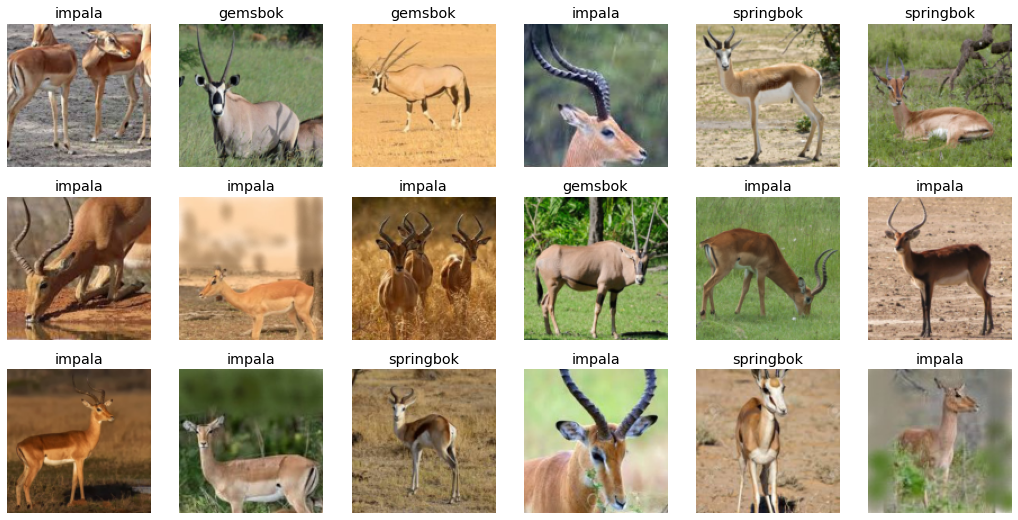

In [13]:
dls.valid.show_batch(max_n=18, nrows=3)

###Resize the images### 
All images should be square and shoulf fit the required size so that they can be used easily.Also define the dls path.

Note there are a few options for fixing the images in the code, it is also recomended that the images uploaded should fit a square ratio this will improve the speed and accuracy.
Watching the video the "RandomResizeCrop" seems to be the best option.
Note, you can adjsut the min_scale and this also affects the accuracy of the final result, below I tried 0.3, 0.5 and 0.4. It seemed that 0.4 gave a slightly better result for this image set

In [14]:
animals = animals.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.4),
    batch_tfms=aug_transforms())
dls = animals.dataloaders(path)
dls.vocab

['gemsbok', 'impala', 'springbok']

###Learning Graph###
Take a sample and evaluate the learning rate v loss to help establish the fit parameters
This is a cool tool that allows you to visualise where the best fit will be, in this example the graph bottoms out at about a loss of 0.8 and learning rate of 1e-1 Where the graph starts to climb that is where you are getting over fitting so you need to train on the downward slope of the curve. 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


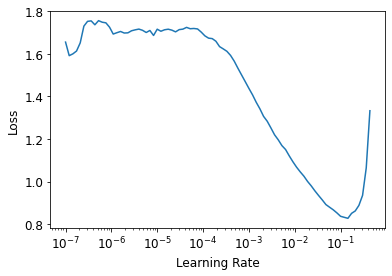

In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

###Best Learning fit###
Evaluate the fit through one cycle look for best fit epochs v learning rate (use the graph above and optimise)
1. Best learning rate in the graphy above was 1e-1 becasue this so close to the bottom of the curve one step back is best, in this case 1e-2 was chosen
2. Number of epochs can be found by looking at the results if they improve add more to see when they are optimised.
3. Learning rate and time should be optimised, in this case resnet34 yeilded better results but time was longer

In [16]:
learn.fit_one_cycle(18, 1e-2)

###Confusion Plot###
Use a Confusion Plot to evaluate the number of images that were misclassified. 
This is usefull to evaluate the accuracy of the model

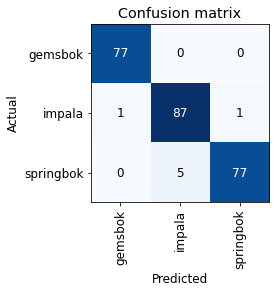

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

###Unfreeze###
Unfreese the full sets and apply fit limits to optimize learning.
Unfreeze in this exercise as the data set is not pretrained

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(12, lr_max=slice(2e-2,2e-4))

In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

View the confused images

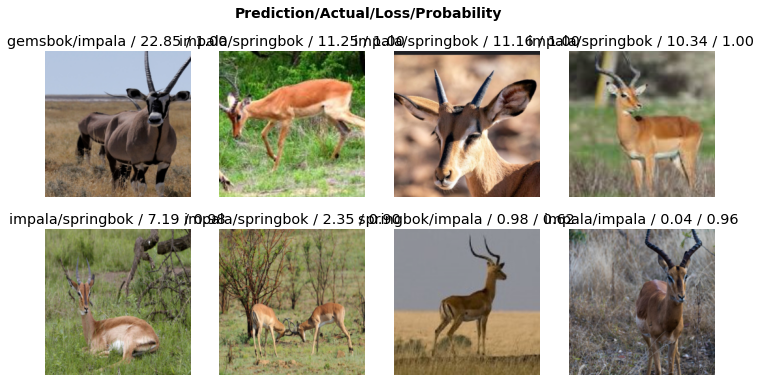

In [20]:
interp.plot_top_losses(8, nrows=2)

###Cleaner###
The cleaner allows you to take out or reclassify images that are confused ... cleaning the DB imprives the accuracy of the model.
Find the images that were confused and delete them

In [19]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [21]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

##Publishing##
The project is trained and ready to publish, the next set of code is the prep for publishing

In [22]:
learn.export()

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [26]:
learn_inf.predict('/content/gdrive/MyDrive/Colab Notebooks/projects/animals/impala/00000004.jpg')

('impala', tensor(1), tensor([6.5515e-09, 1.0000e+00, 3.0515e-06]))

In [27]:
learn_inf.dls.vocab

['gemsbok', 'impala', 'springbok']

In [28]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [38]:
btn_upload = SimpleNamespace(data = ['/content/gdrive/MyDrive/Colab Notebooks/projects/animals_test/ImpalaTest002.JPG'])

In [39]:
img = PILImage.create(btn_upload.data[-1])

In [40]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [41]:
pred,pred_idx,probs = learn_inf.predict(img)

In [42]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: impala; Probability: 0.9996')

In [43]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [45]:
btn_upload = widgets.FileUpload()

In [46]:
VBox([widgets.Label('Select the Animal to Identify'),
      btn_upload, btn_run, out_pl, lbl_pred])